$$\gamma_{mk} = \alpha_k + \sum_{n=1}^{N_m} \phi_{mnk}$$


$$ \lamda_{kv} = \eta_v + \sum_{m=1}^M \sum_{n=1}^{N_m}  \phi_{nmk} w_{mn}^v $$


In [58]:
import numpy as np
from holoviews.plotting.bokeh.styles import alpha
from scipy.special import digamma, polygamma, gammaln
from copy import deepcopy


class LDAEM(object):
    def __init__(self,K):
        """
        变分EM算法实现LDA模型
        :param K: 主题个数
        :param M: 文档个数
        :param Nm: 第m个文档的单词个数
        :param N: 文本单词个数列表，(M,)
        :param V: 单词集合的个数
        :param tockens: 单词tockens
        :param gamma: 变分参数，对应文档主题，(M, K)
        :param lamda: 变分参数，对应单词主题，(K, V)
        :param phi: 变分参数，对应文本中单词的主题(M, Nm, K)
        :param alpha: 模型参数文档主题theta的参数，(K,)
        :param eta: 模型参数单词主题beta的参数，(V,)
        """
        self.K = K

        self.M = None
        self.V = None
        self.tockens = None
        self.N = None

        self.params = {
            'gamma': None,
            'lamda': None,
            'phi': None,
            'alpha': None,
            'eta': None
        }

    def _init_params(self):
        max_Nm = max(self.N)  # 找到最大单词数
    
        # 初始化变分参数
        gamma = np.random.dirichlet(100 * np.ones(self.K), self.M)
    
        # 创建 phi 数组，并填充到最大长度
        phi = np.zeros((self.M, max_Nm, self.K))
        for m, Nm in enumerate(self.N):
            phi[m, :Nm] = np.random.dirichlet(100 * np.ones(self.K), Nm)
    
        # 初始化模型参数
        alpha = np.ones(self.K)
        eta = np.ones(self.V)
    
        self.params = {
            'gamma': gamma,
            'lamda': np.random.dirichlet(100 * np.ones(self.V), self.K),
            'phi': phi,
            'alpha': alpha,
            'eta': eta
        }
    def _update_gamma(self):
        """
         $$\gamma_{mk} = \alpha_k + \sum_{n=1}^{N_m} \phi_{mnk}$$
        """
        alpha = deepcopy(self.params['alpha'])
        phi = deepcopy(self.params['phi'])

        # 预定义占位
        gamma = np.zeros((self.M, self.K))

        for m in range(self.M):
            gamma[m] = alpha + np.sum(phi[m], axis=0)

        # 归一化
        gamma = np.array([gamma[:, k] / np.sum(gamma, axis=1) for k in range(self.K)]).T
        return gamma

    def _update_lamda(self):
        """
        $$\lamda_{kv} = \eta_v + \sum_{m=1}^M \sum_{n=1}^{N_m}  \phi_{nmk} w_{mn}^v $$
        :return:
        """
        eta = deepcopy(self.params['eta'])
        phi = deepcopy(self.params['phi'])

        lamda = np.zeros((self.K, self.V))

        for k in range(self.K):
            for v in range(self.V):
                sum_mn = 0
                for m in range(self.M):
                    for n in range(self.N[m]):
                        sum_mn += phi[m][n][k] * (self.texts[m][n] == self.tockens[v])
                lamda[k][v] = sum_mn + eta[v]

        # 归一化
        lamda = np.array([lamda[k] / np.sum(lamda[k]) for k in range(self.K)])
        return lamda


    def _update_phi(self):
        """
        $$\phi_{mnk} \ltimes \exp(\Psi(\gamma_{mk})
        +\sum_{v=1}^V w_{mn}^v  \Psi(\lamda_{kv}) - \Psi(\sum_{s=1}^V \lamda_{ks}))$$
        计算中需要归一化
        :return:
        """
        gamma = deepcopy(self.params['gamma'])
        lamda = deepcopy(self.params['lamda'])

        max_n = max(self.N)
        phi = np.ones((self.M, max_n, self.K))

        for m in range(self.M):
            for n in range(self.N[m]):
                sum_k = 0
                phi_mn_k_list = np.zeros(self.K)
                for k in range(self.K):
                    sum_digamma_lamda_k = 0
                    for v in range(self.V):
                        sum_digamma_lamda_k += digamma(lamda[k][v]) * (self.tockens[v] == self.texts[m][n])
                    a = digamma(gamma[m][k]) + sum_digamma_lamda_k + digamma(np.sum(lamda[k]))
                    # 为了防止指数增长中的内存溢出，限定一个阈值
                    if a > 20:
                        a = 20
                    sum_k += np.exp(a)
                    phi_mn_k_list[k] = np.exp(a)
                # 将k维度上的数据归一化后赋值
                phi[m][n] = phi_mn_k_list / sum_k

        return phi

    def _E_step(self):
        """
        更新变分参数，为了方便理解，将gamma,lamda, phi分别计算
        :return:
        """
        # 更新gamma
        gamma = self._update_gamma()

        # 更新lamda
        lamda = self._update_lamda()

        # 更新phi
        phi = self._update_phi()

        # 将结果写入
        self.params['gamma'] = gamma
        self.params['lamda'] = lamda
        self.params['phi'] = phi
        print(gamma,lamda,phi)

    def _update_alpha(self, max_iter=1000, tol=0.1):
        """
        $$\alpha_{new} = \alpha_{old} - H(\alpha_{old})^{-1} g(\alpha_{old})$$
        其中g(alpha)是关于alpha的一阶导数
        H(alpha)是关于alpha的Henssian矩阵
        :return:
        """
        alpha = deepcopy(self.params['alpha'])
        gamma = deepcopy(self.params['gamma'])
        for _ in range(max_iter):
            alpha_old = alpha

            # 计算alpha的一阶导数
            # np.tile是将数据扩展
            g = self.M * (digamma(np.sum(alpha)) - digamma(alpha)) + \
                np.sum(
                    digamma(gamma) - np.tile(digamma(np.sum(gamma, axis=1)), (self.K, 1)).T,
                    axis=0
                )

            # 计算Hessen矩阵
            h = -1 * self.M * polygamma(1, alpha)
            z = self.M * polygamma(1, np.sum(alpha))
            c = np.sum(g / h) / (z ** (-1.0) + np.sum(h ** (-1.0)))

            # update alpha
            alpha = alpha - (g - c) / h

            # 设置终止条件
            if np.sqrt(np.mean(np.square(alpha - alpha_old))) < tol:
                break
        return alpha

    def _update_eta(self, max_iter=1000, tol=0.1):
        """
        $$\eta_{new} = \eta_{old} - H(\eta_{old})^{-1}g(\eta_{old})$$
        """
        eta = deepcopy(self.params['eta'])
        lamda = deepcopy(self.params['lamda'])

        for _ in range(max_iter):
            eta_old = eta

            g = self.K * (digamma(np.sum(eta)) - digamma(eta)) + \
                np.sum(
                    digamma(lamda) - np.tile(digamma(np.sum(lamda, axis=1)), (self.V, 1)).T,
                    axis=0
                )

            h = -1 * self.K * polygamma(1, eta)
            z = self.K * polygamma(1, np.sum(eta))
            c = np.sum(g / h) / (z ** (-1.0) + np.sum(h ** (-1.0)))

            eta = eta - (g - c) / h

            if np.sqrt(np.mean(np.square(eta - eta_old))) < tol:
                break
        return eta


    def _M_step(self):
        """
        更新模型参数，alpha, eta
        :return:
        """
        # 更新alpha
        alpha = self._update_alpha()

        # 更新eta
        eta = self._update_eta()

        self.params['alpha'] = alpha
        self.params['eta'] = eta
        print(alpha,eta)
    def fit(self, texts, tokens, max_iter=10):
        """
        训练入口
        :param texts:
        :param tokens:
        :param max_iter:
        :return:
        """
        self.M = len(texts)
        self.tockens = tokens
        self.V = len(tokens)
        self.N = np.array([len(d) for d in texts])

        self.texts = texts

        self._init_params()

        for i in range(max_iter):
            print('iter: ', i + 1)
            print(self.V)

            self._E_step()
            self._M_step()


<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:78: SyntaxWarning: invalid escape sequence '\l'
<>:101: SyntaxWarning: invalid escape sequence '\p'
<>:186: SyntaxWarning: invalid escape sequence '\e'
<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:78: SyntaxWarning: invalid escape sequence '\l'
<>:101: SyntaxWarning: invalid escape sequence '\p'
<>:186: SyntaxWarning: invalid escape sequence '\e'
C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_11396\634135734.py:61: SyntaxWarning: invalid escape sequence '\g'
  """
C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_11396\634135734.py:78: SyntaxWarning: invalid escape sequence '\l'
  """
C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_11396\634135734.py:101: SyntaxWarning: invalid escape sequence '\p'
  """
C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_11396\634135734.py:186: SyntaxWarning: invalid escape sequence '\e'
  """


In [59]:
import jieba
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import chardet
from collections import Counter

# 定义停用词加载函数
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='gbk') as f:
        chinese_stopwords = f.read().splitlines()
    
    # 加载nltk的英文停用词
    nltk_english_stopwords = set(nltk.corpus.stopwords.words('english'))
        
    # 手动添加的停用词
    manual_stopwords = {'1','2','3','4','5','6','7','8','9','0','逾'}
        
    # 合并所有停用词，使用 union 方法
    all_stopwords = set().union(
        chinese_stopwords,
        nltk_english_stopwords,
        manual_stopwords
    )
    
    return all_stopwords

# 文本预处理函数（使用 jieba 进行分词）
def preprocess_text(text, stop_words):
    words = jieba.lcut(text)
    filtered_words = [word for word in words if word.strip() and word not in stop_words]
    return ' '.join(filtered_words)

if __name__ == "__main__":
    # 检测CSV文件编码
    file_path_csv = 'news_titles.csv'
    with open(file_path_csv, "rb") as file:
        detected_encoding = chardet.detect(file.read())['encoding']
    
    # 加载新闻标题数据
    data = pd.read_csv(file_path_csv, encoding=detected_encoding)
    titles = data['Title'].tolist()

    # 加载停用词
    stop_words = load_stopwords("stop_words.txt")

    # 预处理文档
    processed_titles = [preprocess_text(title, stop_words) for title in titles]

    # 创建文档-词项矩阵
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, token_pattern=r"(?u)\b\w+\b")
    dtm = vectorizer.fit_transform(processed_titles)
    vocabulary = vectorizer.get_feature_names_out()

    # 准备LDAEM模型所需的数据格式
    texts = [[vocabulary[index] for index in doc.nonzero()[1]] for doc in dtm]
    N = [len(doc) for doc in texts]

    # 初始化 LDAEM 模型
    ldaem = LDAEM(K=10)  # 设定主题数量

    # 训练模型
    ldaem.fit(texts, vocabulary.tolist(), max_iter=10)

iter:  1
69
[[0.10013498 0.09962767 0.10017537 0.09876572 0.10125555 0.09850466
  0.10160715 0.09885941 0.09917506 0.10189444]
 [0.10208621 0.10100707 0.10101906 0.09849305 0.10435031 0.09782687
  0.09757925 0.10005087 0.09901639 0.09857092]
 [0.10067675 0.10133075 0.10064567 0.09754557 0.1002303  0.09912408
  0.09957128 0.09956796 0.09989711 0.10141052]
 [0.10109574 0.10043191 0.09822538 0.10095609 0.09973672 0.09895575
  0.09879214 0.09828719 0.10156662 0.10195245]
 [0.10203421 0.10006073 0.09989677 0.10028105 0.09783654 0.09972031
  0.09830938 0.10146695 0.10055639 0.09983769]
 [0.10024617 0.09887984 0.10209789 0.09941345 0.09890676 0.10251987
  0.1009269  0.1004529  0.09870542 0.0978508 ]
 [0.10099493 0.09835116 0.09886354 0.10067522 0.09994082 0.09797129
  0.09966604 0.09936956 0.10123478 0.10293267]
 [0.09877623 0.09763039 0.10197895 0.09952091 0.10104081 0.10048884
  0.09956764 0.10208784 0.10146786 0.09744053]
 [0.09759348 0.1019574  0.10137719 0.1012073  0.09944865 0.09769145


In [35]:
def plot_wordclouds(lda_model, tokens, num_topics, n_top_words=10):
    """
    绘制每个主题的词云。
    :param lda_model: LDAEM 模型实例
    :param tokens: 词汇表
    :param num_topics: 主题数量
    :param n_top_words: 每个主题显示的关键词数量
    """
    lamda = lda_model.params['lamda']
    feature_names = tokens
    
    plt.figure(figsize=(20, 15))
    for k in range(num_topics):
        topic = lamda[k]
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        frequencies = {feature_names[i]: topic[i] for i in top_features_ind}
        
        plt.subplot((num_topics-1)//5 + 1, 5, k+1)
        wordcloud = WordCloud(font_path='simhei.ttf', width=400, height=300, background_color='white').generate_from_frequencies(frequencies)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {k}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

IndexError: index 5 is out of bounds for axis 0 with size 5

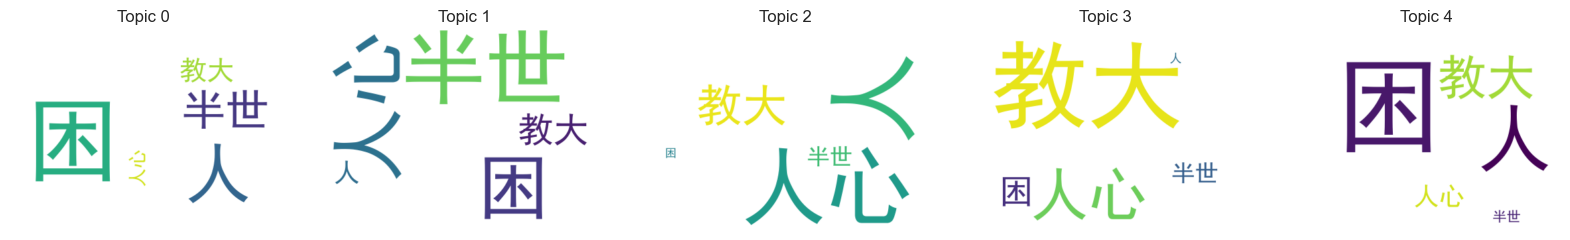

In [45]:
plot_wordclouds(lda_model, tokens, num_topics=10, n_top_words=10)   

In [48]:
import pyLDAvis

In [51]:
# 获取每个词在整个语料库中的总频率
term_frequency = dtm.sum(axis=0).A1

# 获取文档长度（即每个文档中词汇的总数量）
doc_lengths =dtm.sum(axis=1).A1
# 准备 LDA 可视化数据
data = pyLDAvis.prepare(lda_model.params['alpha'], 
                        doc_topic_dists=lda_model.params['gamma'],
                        vocab=tokens, 
                        term_frequency=term_frequency,
                        doc_lengths=doc_lengths,
                        mds='tsne')
# 如果你在 Jupyter Notebook 中工作，可以使用 enable_notebook()
pyLDAvis.enable_notebook()

# 显示可视化面板
pyLDAvis.display(data)

ValidationError: 
 * Number of terms in vocabulary does not match the number of columns of topic_term_dists (where each row of topic_term_dists is a probability distribution of terms for a given topic)
 * Length of term_frequency not equal to the number of terms in the number of terms in the vocabulary (len of vocab)
 * Not all rows (distributions) in topic_term_dists sum to 1.

In [52]:
lda_model.params['alpha']

array([0.2, 0.2, 0.2, 0.2, 0.2])